In [172]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [173]:
import numpy as np
import pandas as pd

In [174]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [175]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

In [176]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [177]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [178]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [179]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [180]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(bind=engine)

# Exploratory Climate Analysis

In [181]:
# Creating query to identify the last date in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(last_date)

('2017-08-23',)


In [182]:
# Print(last_date) returns '2017-08-23' which means we will be working with period between 2016-08-23 and 2017-08-23
prcp_year = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).all()

In [183]:
# Creating percipitation DataFrame, reseting the date to datetime format and sedding index to date
prcp_df = pd.DataFrame(prcp_year, columns = ['Date', 'Prcp'])
prcp_df['Date'] = pd.to_datetime(prcp_df['Date'], format='%Y/%m/%d')
prcp_df.set_index(prcp_df['Date'])
prcp_df.head()

,Date,Prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


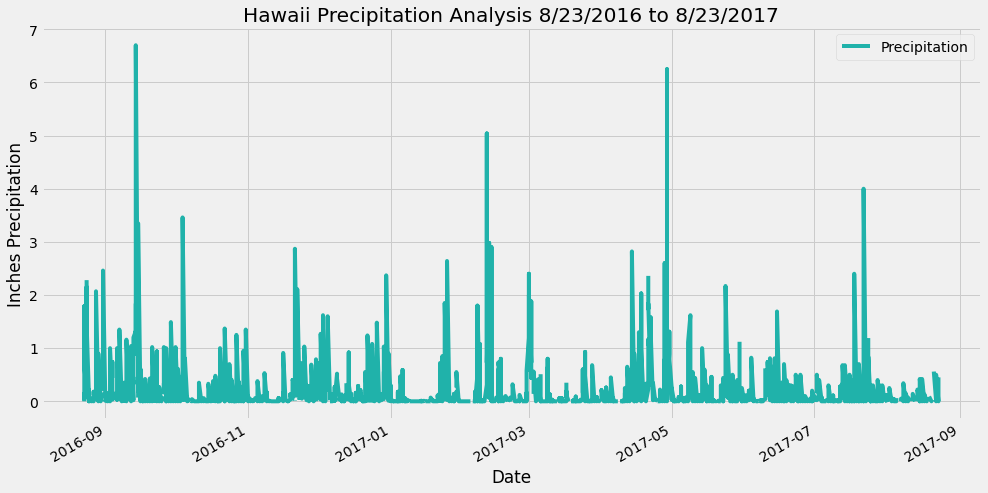

<Figure size 432x288 with 0 Axes>

In [184]:
# Plot the results using the DataFrame plot method.
prcp_df.plot('Date', 'Prcp', color="lightseagreen", figsize=(15, 8))
plt.xlabel("Date")
plt.ylabel("Inches Precipitation")
plt.title("Hawaii Precipitation Analysis 8/23/2016 to 8/23/2017")
plt.legend(["Precipitation"])
plt.savefig("precipitation.png") 
#plt.tight_layout()
plt.show()
plt.savefig("Images/precipitation_analysis.png")

In [185]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


#  Station Analysis

In [186]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement).group_by(Measurement.station).count()
print("There is a total of {} stations.".format(stations))

There is a total of 9 stations.


In [187]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [188]:
most_active_station = session.query(Measurement.station).group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).first()

#most_active_station = most_active_station [0]
#most_active_station
print(f"The station with the highest number of observations is {most_active_station}")

The station with the highest number of observations is ('USC00519281',)


In [189]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()


[(54.0, 85.0, 71.66378066378067)]

In [190]:
# Choose the station with the highest number of temperature observations.
temp = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
        order_by(func.count(Measurement.tobs).desc()).first()

temp

('USC00519281', 2772)

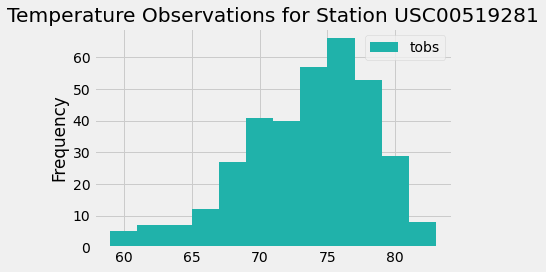

In [191]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
        filter(Measurement.date >= prev_year).all()

df = pd.DataFrame(results, columns =['tobs'])
#print(df)
df.plot.hist(bins=12, color="lightseagreen")
plt.title("Temperature Observations for Station USC00519281")
plt.tight_layout()
plt.savefig("Images/histogram_tobs.png")

## Bonus Challenge Assignment

In [192]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [200]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
results = calc_temps('2016-08-23', '2017-08-23')
print(results)


[(58.0, 74.59058295964125, 87.0)]


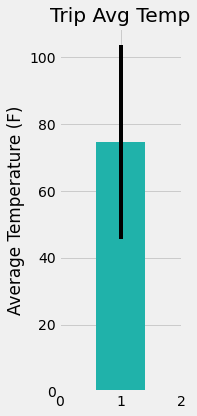

In [201]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

y = 74.59058295964125
yerr = 87.0-58.0

plt.figure(figsize=(3,6))

plt.bar(1, y, yerr=yerr, color="lightseagreen")
plt.title("Trip Avg Temp")
plt.ylabel("Average Temperature (F)")
plt.xlim((0, 2))
plt.tight_layout()
plt.savefig("Images/trip_temp.png")


In [204]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
 


In [196]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [197]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [198]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [199]:
# Plot the daily normals as an area plot with `stacked=False`
